In [111]:
# COCO classes
CLASSES = [
    'person', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'truck', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A2',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'cow',
    'sheep', 'cow', 'zebra', 'giraffe', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A3', 'N/A4', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'skateboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'bowl', 'wine glass',
    'cup', 'fork', 'orange', 'broccoli', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A6', 'dining table', 'N/A7',
    'N/A8', 'toilet', 'N/A9', 'tv', 'laptop', 'clock', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A10',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

coco_idx_to_label = {idx: label for idx, label in enumerate(CLASSES)}

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]



In [74]:
for i, c in enumerate(CLASSES):
    print(i, c)

0 N/A
1 person
2 bicycle
3 car
4 motorcycle
5 airplane
6 bus
7 train
8 truck
9 boat
10 traffic light
11 fire hydrant
12 N/A
13 stop sign
14 parking meter
15 bench
16 bird
17 cat
18 dog
19 horse
20 sheep
21 cow
22 elephant
23 bear
24 zebra
25 giraffe
26 N/A
27 backpack
28 umbrella
29 N/A
30 N/A
31 handbag
32 tie
33 suitcase
34 frisbee
35 skis
36 snowboard
37 sports ball
38 kite
39 baseball bat
40 baseball glove
41 skateboard
42 surfboard
43 tennis racket
44 bottle
45 N/A
46 wine glass
47 cup
48 fork
49 knife
50 spoon
51 bowl
52 banana
53 apple
54 sandwich
55 orange
56 broccoli
57 carrot
58 hot dog
59 pizza
60 donut
61 cake
62 chair
63 couch
64 potted plant
65 bed
66 N/A
67 dining table
68 N/A
69 N/A
70 toilet
71 N/A
72 tv
73 laptop
74 mouse
75 remote
76 keyboard
77 cell phone
78 microwave
79 oven
80 toaster
81 sink
82 refrigerator
83 N/A
84 book
85 clock
86 vase
87 scissors
88 teddy bear
89 hair drier
90 toothbrush


In [70]:
import torch
import matplotlib.pyplot as plt
import torchvision

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        output_tensor = []
        for t, m, s in zip(tensor, self.mean, self.std):
            output_tensor.append(t.mul(s).add(m))
            # t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return torch.stack(output_tensor, dim=0)

unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(img, labels, boxes, mask=None, classes=CLASSES):
    h, w = img.shape[1:]
    if mask != None:
        # width
        if torch.where(mask[0])[0].shape[0] > 0:
            mask_w = torch.where(mask[0])[0][0]
            w = min(w, mask_w)
        if torch.where(mask[:, 0])[0].shape[0]:
            mask_h = torch.where(mask[:, 0])[0][0]
            h = min(h, mask_h)
            
    boxes = rescale_bboxes(boxes, (w, h))
    plt.figure(figsize=(16,10))
    #unimage = unnorm(img)
    #image = (unimage*256).to(torch.uint8)
    #image = unimage
    image = img
    pil_img = torchvision.transforms.functional.to_pil_image(image)
    plt.imshow(pil_img)
    
    ax = plt.gca()
    colors = COLORS * 100
    for label, (xmin, ymin, xmax, ymax), c in zip(labels, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{classes[label.item()]}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [3]:
from argparse import Namespace
args = Namespace(config='configs/rtdetr/rtdetr_r50vd_6x_coco.yml', resume=None, tuning=None, test_only=False, amp=False, seed=None)

In [5]:
import os 
import sys
import argparse

import src.misc.dist as dist 
from src.core import YAMLConfig 
from src.solver import TASKS

dist.init_distributed()
if args.seed is not None:
    dist.set_seed(args.seed)

assert not all([args.tuning, args.resume]), \
    'Only support from_scrach or resume or tuning at one time'

cfg = YAMLConfig(
    args.config,
    resume=args.resume, 
    use_amp=args.amp,
    tuning=args.tuning
)

solver = TASKS[cfg.yaml_cfg['task']](cfg)

/traindata/maksim/miniconda3/envs/rtdetr/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/traindata/maksim/miniconda3/envs/rtdetr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Not init distributed mode.


In [14]:
solver.cfg.epochs = 0

In [16]:
solver.fit()

Start training
number of params: 42862860


Epoch: [0]  [    0/29571]  eta: 16 days, 15:19:36  lr: 0.000010  loss: 50.9939 (50.9939)  loss_vfl: 0.1846 (0.1846)  loss_bbox: 2.2747 (2.2747)  loss_giou: 1.9276 (1.9276)  loss_vfl_aux_0: 0.1454 (0.1454)  loss_bbox_aux_0: 2.3599 (2.3599)  loss_giou_aux_0: 1.9949 (1.9949)  loss_vfl_aux_1: 0.1688 (0.1688)  loss_bbox_aux_1: 2.2791 (2.2791)  loss_giou_aux_1: 1.9430 (1.9430)  loss_vfl_aux_2: 0.1832 (0.1832)  loss_bbox_aux_2: 2.3010 (2.3010)  loss_giou_aux_2: 1.9462 (1.9462)  loss_vfl_aux_3: 0.1827 (0.1827)  loss_bbox_aux_3: 2.3017 (2.3017)  loss_giou_aux_3: 1.9054 (1.9054)  loss_vfl_aux_4: 0.1824 (0.1824)  loss_bbox_aux_4: 2.3155 (2.3155)  loss_giou_aux_4: 1.9225 (1.9225)  loss_vfl_aux_5: 0.1772 (0.1772)  loss_bbox_aux_5: 2.3572 (2.3572)  loss_giou_aux_5: 1.9495 (1.9495)  loss_vfl_dn_0: 0.8620 (0.8620)  loss_bbox_dn_0: 1.1202 (1.1202)  loss_giou_dn_0: 1.3512 (1.3512)  loss_vfl_dn_1: 0.8558 (0.8558)  loss_bbox_dn_1: 1.1202 (1.1202)  loss_giou_dn_1: 1.3512 (1.3512)  loss_vfl_dn_2: 0.8882 (0.

KeyboardInterrupt: 

In [115]:
solver.train_dataloader.dataset

Dataset CocoDetection
    Number of datapoints: 118287
    Root location: /traindata/maksim/datasets/coco/train2017/
     img_folder: /traindata/maksim/datasets/coco/train2017/
     ann_file: /traindata/maksim/datasets/coco/annotations/instances_train2017.json
     return_masks: False
     transforms:
       Compose(
          RandomZoomOut(p=0.5, fill=0, side_range=(1.0, 4.0))
          RandomIoUCrop(min_scale=0.3, max_scale=1, min_aspect_ratio=0.5, max_aspect_ratio=2, options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0], trials=40, p=0.8)
          SanitizeBoundingBox(min_size=1, labels_getter=default)
          RandomHorizontalFlip(p=0.5)
          Resize(size=[640, 640], interpolation=InterpolationMode.BILINEAR, antialias=warn)
          ToImageTensor()
          ConvertDtype()
          SanitizeBoundingBox(min_size=1, labels_getter=default)
          ConvertBox(out_fmt=cxcywh, normalize=True)
    )

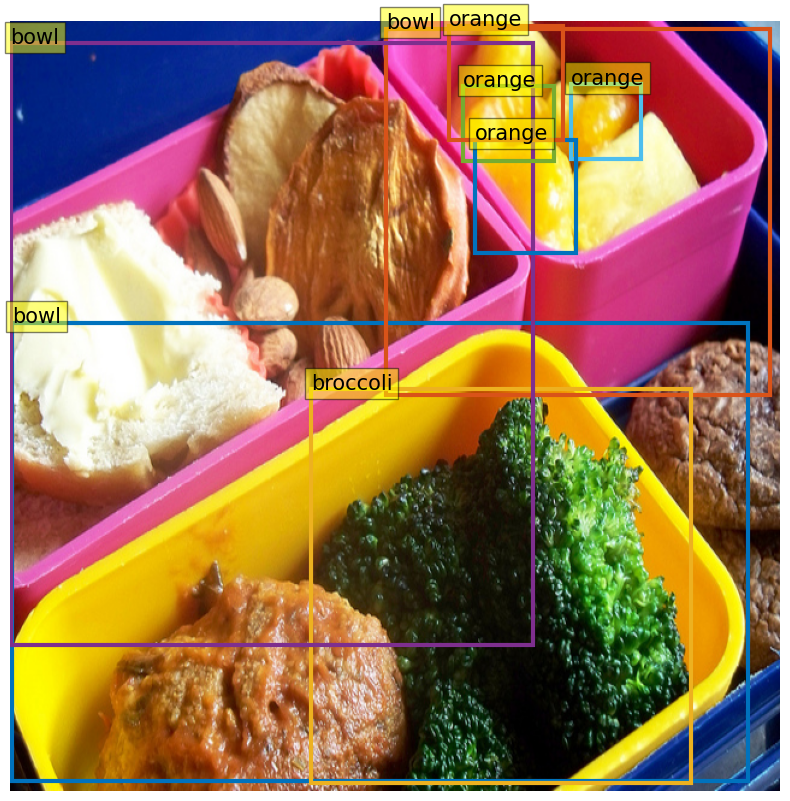

In [118]:
sample = solver.train_dataloader.dataset[0]
plot_results(sample[0], sample[1]["labels"], sample[1]["boxes"], classes=CLASSES)

In [108]:
for batch in solver.train_dataloader:
    break
batch

(tensor([[[[0.6510, 0.6510, 0.6549,  ..., 0.6745, 0.6706, 0.6667],
           [0.6510, 0.6510, 0.6549,  ..., 0.6745, 0.6706, 0.6667],
           [0.6549, 0.6549, 0.6549,  ..., 0.6784, 0.6745, 0.6706],
           ...,
           [0.3451, 0.3490, 0.3451,  ..., 0.4353, 0.6863, 0.9373],
           [0.3373, 0.3412, 0.3373,  ..., 0.4784, 0.7176, 0.9451],
           [0.3294, 0.3333, 0.3294,  ..., 0.5098, 0.7412, 0.9490]],
 
          [[0.8314, 0.8314, 0.8353,  ..., 0.8471, 0.8431, 0.8392],
           [0.8314, 0.8314, 0.8353,  ..., 0.8471, 0.8431, 0.8392],
           [0.8353, 0.8353, 0.8353,  ..., 0.8471, 0.8471, 0.8431],
           ...,
           [0.4118, 0.4157, 0.4157,  ..., 0.4431, 0.7059, 0.9569],
           [0.4039, 0.4078, 0.4078,  ..., 0.4941, 0.7490, 0.9725],
           [0.4000, 0.4039, 0.4039,  ..., 0.5294, 0.7765, 0.9804]],
 
          [[0.9333, 0.9333, 0.9373,  ..., 0.9608, 0.9569, 0.9529],
           [0.9333, 0.9333, 0.9373,  ..., 0.9608, 0.9569, 0.9529],
           [0.9373, 0.93

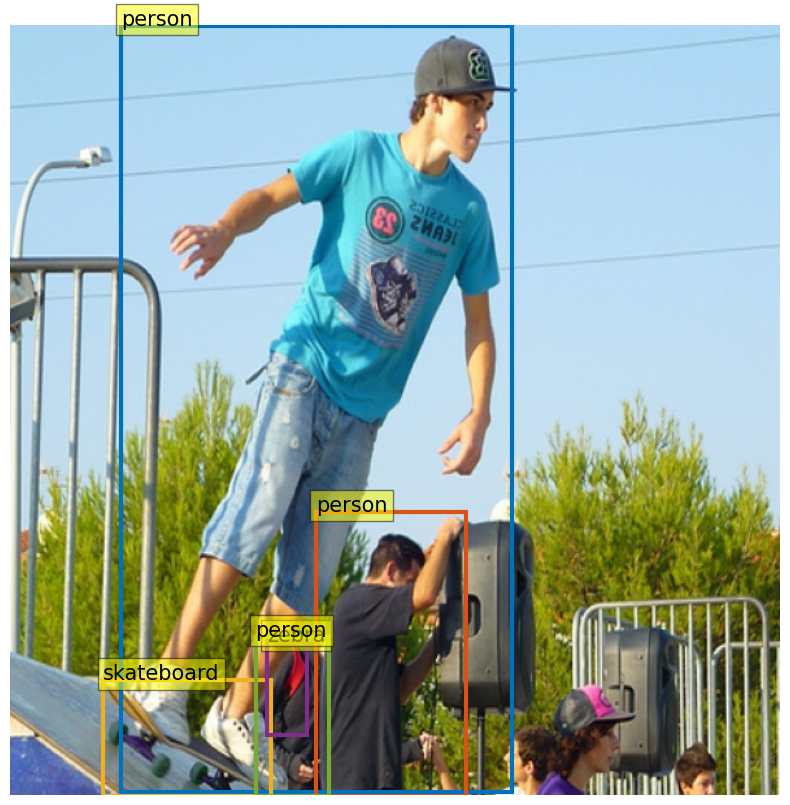

In [114]:
batch_idx = 0
plot_results(batch[0][batch_idx], batch[1][batch_idx]["labels"], batch[1][batch_idx]["boxes"], classes=CLASSES)

In [122]:
solver.model

RTDETR(
  (backbone): PResNet(
    (conv1): Sequential(
      (conv1_1): ConvNormLayer(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (norm): FrozenBatchNorm2d(32, eps=1e-05)
        (act): ReLU(inplace=True)
      )
      (conv1_2): ConvNormLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): FrozenBatchNorm2d(32, eps=1e-05)
        (act): ReLU(inplace=True)
      )
      (conv1_3): ConvNormLayer(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): FrozenBatchNorm2d(64, eps=1e-05)
        (act): ReLU(inplace=True)
      )
    )
    (res_layers): ModuleList(
      (0): Blocks(
        (blocks): ModuleList(
          (0): BottleNeck(
            (branch2a): ConvNormLayer(
              (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (norm): FrozenBatchNorm2d(64, eps=1e-05)
    

In [121]:
preds = solver.model(batch[0], batch[1])
preds

{'pred_logits': tensor([[[-3.7564, -4.7063, -3.9619,  ..., -3.9965, -4.4477, -3.5991],
          [-3.9998, -5.3627, -3.7042,  ..., -5.2659, -5.4884, -3.3187],
          [-4.2910, -4.1452, -5.0196,  ..., -4.5233, -3.7392, -3.8611],
          ...,
          [-3.4636, -3.9075, -4.3219,  ..., -5.0001, -5.6680, -4.7859],
          [-4.7309, -5.1463, -5.7315,  ..., -4.5571, -4.9508, -4.9967],
          [-4.3568, -5.4147, -3.5145,  ..., -3.3763, -5.8650, -3.8987]],
 
         [[-3.8891, -3.7196, -4.7794,  ..., -3.6868, -5.6546, -4.6714],
          [-4.7511, -4.1777, -5.5191,  ..., -4.8955, -5.4886, -4.2137],
          [-3.7493, -5.3995, -5.1990,  ..., -4.7392, -5.2851, -4.0064],
          ...,
          [-3.6576, -5.1908, -4.8313,  ..., -3.9882, -5.5455, -4.4490],
          [-4.0980, -4.2614, -3.9051,  ..., -3.7120, -5.3229, -4.0484],
          [-4.1113, -4.1236, -4.5266,  ..., -3.3036, -4.9028, -3.0232]],
 
         [[-3.1854, -3.9143, -4.8425,  ..., -4.1507, -6.0281, -4.9054],
          [-3